In [1]:
using PyPlot
using LinearAlgebra
using Statistics
using Random

# Welcome Back!

### I hope you all are staying safe and healthy.

### Logistics

* All lectures and office hours will now be taking place on zoom. Zoom links for office hours will be posted on piazza and on the office hours calendar.

* There are a few surveys going out on Piazza about what time zones you are in, etc. Please fill these out, as these will help us adjust our office hour times to best help you!

* Problem Set 3 will be due today (+2 late days), Programming Assignment 3 will be due on Wednesday (+2 late days)

  * **If it would be helpful to have an extension, please ask!** The goal of making these things due soon is to start building momentum again and swap things back into your memory...but if having more time will advance your learning, I'm happy to give you more time.

* You can now switch this class to S/U. I will **not be treating you any differently if you switch your grade basis**! That is, I will grade your work and provide feedback in the same way as if you were taking the course for a letter grade, and then if your final letter grade would have been a C- or above, you get an S (otherwise, you get a U).

> Undergraduates will have until May 12, the last day of instruction, to drop a course without a W or change the grading basis of a course to S/U. This applies to any full Spring 2020 semester course, including courses that did not previously offer an S/U grading option, as well as 7-week courses offered in the second half of the semester. Between May 12 and May 23, the last day of the semester, students can still drop any of their courses with a W and petition to change the grading basis to S/U. Every transcript will include a notation that explains the anomalies associated with the Spring 2020 semester.
> 
> Courses in which a grade of S is earned will count toward entering and meeting major and minor requirements and satisfy college requirements for good standing and graduation. Credits taken as S/U this semester will be excluded from the maximum allowable S/U credits toward major or graduation requirements. As always, grades of S/U are not given grade point values. Note that the S/U option is not the same as a Pass/Fail option; the S/U threshold for successfully completing and earning credit for a course is a minimum grade of C-. 

* I know that this is a difficult time for many of you. If it would help to chat about anything, please let me know, and we can find a time. This is a trying time for everyone, and my goal for the rest of the semester is to enable your learning as much as possible, not to try to add to your stress.

# Lecture 14: Hyperparameter Optimization

### CS4787 --- Principles of Large-Scale Machine Learning Systems

$$\newcommand{\Exv}[2][]{\mathbf{E}_{#1}\left[ #2 \right]}$$

So far in class we've talked about:

* learning algorithms, such as SGD;
* ways to accelerate these learning algorithms, such as momentum;
* and deep learning.

Each one of these methods introduces many **hyperparameters** that we need to set for the algorithms to run efficiently.

And we saw that <span class="problem">setting the hyperparameters suboptimally can lead to slow convergence!<span>

Formally: what is a hyperparameter?

>A **hyperparameter** is a parameter that is set before the main learning algorithm is run, in contrast to other model parameters that are assigned during learning.

<span class="question">Question: What hyperparameters have we seen so far in this course? What bad things can happen if we set them inefficiently?</span>

<div class="breakout">Breakout Discussion</div>

**Examples of hyperparameters:**

(...)

One way to get a feeling for what hyperparameters do is **theory**. We've seen some amount of theory in this course.
One thing that theory can do is **give us a recipe for assigning hyperparameters**.

* For example, theory can tell us how to set hyperparameters for strongly convex optimization if we know the strong convexity constant $\mu$ and the Lipschitz constant $L$.

   * e.g. $\alpha = \frac{1}{L}$ for gradient descent

* Setting hyperparameters according to theory generally gives us the right asymptotic rate.
* And it gives us a good sense of what order of magnitude the hyperparameters should probably have, and how they should scale with problem parameters and other hyperparameters. 
* We can even (sometimes) get the *optimal* setting of hyperparameters for a given problem class. For example, for convex optimzation, we can find the best setting of hyperparameters that makes the algorithm converge for any strongly convex, Lipschitz continuous function with that $\mu$ and $L$.
* <span class="problem">But it can be loose relative to the best setting of the hyperparameters for a particular problem/dataset!</span>

<div class="demo">DEMO</div>

Let's look at using stochastic gradient descent with various methods to optimize logistic regression.
First, we'll generate a training set at random from the generative model associated with logistic regression.

In [2]:
# generate the data
Random.seed!(424242)
d = 20;
N = 10000;
wtrue = randn(d);
wtrue = d^2 * wtrue / norm(wtrue);
X = randn(N, d);
X ./= sqrt.(sum(X.^2; dims=2)); # initialize such that each example x_i has norm 1
Y = (1 ./ (1 .+ exp.(-X * wtrue)) .>= rand(N)) * 2.0 .- 1.0;
gamma = 0.001;

Let's do logistic regression with regularization here. We want to minimize

$$f(w) = \frac{1}{n} \sum_{i=1}^n f_i(w)$$

where our objective samples are of the form

$$f_i(w) = \log \left( 1 + \exp(-y_i x_i^T w) \right) + \frac{\gamma}{2} \| w \|^2$$

and the SGD updates will look like

$$w_{t+1} = w_t + \alpha_t \left( \frac{y_i x_i}{1 + \exp(y_i x_i^T w_t)} - \gamma w_t \right).$$

Let's look at the constants of strong convexity and Lipschitz continuity for this problem, to get a handle on the theory/optimal parameters. If we differentiate the objective twice, we get

$$\nabla^2 f_i(w) = \frac{x_i x_i^T}{(1 + \exp(y_i x_i^T w_t)) (1 + \exp(-y_i x_i^T w_t))} + \gamma I.$$

It's pretty easy to see that, for any $u \in \mathbb{R}$,

$$0 < \frac{1}{(1 + \exp(u)) (1 + \exp(-u))} \le \frac{1}{4},$$

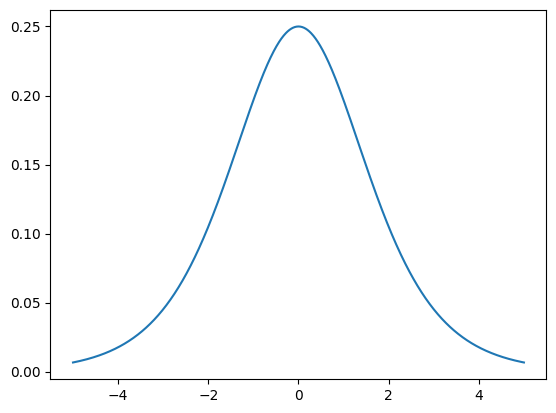

In [3]:
# visually
us = collect(-5:0.01:5);
plot(us, 1 ./ ((1 .+ exp.(us)).*(1 .+ exp.(-us))));

...and so since we initialized such that $\| x_i \|^2 = 1$, from the way we generated the examples, we can approximate 

$$\gamma I \preceq \nabla^2 f_i(w) \preceq \left(\gamma + \frac{1}{4} \right) I.$$

So we can set $\mu = \gamma$ and $L = \gamma + \frac{1}{4}$.
What about bounding the variance of the gradient samples?  

\begin{align*}
    &\hspace{-2em}\mathbf{E}\left[\left\| \nabla f_i(w) - \mathbf{E}\left[ \nabla f_i(w) \right] \right\|^2 \right] \\
    &=
    \mathbf{E}\left[\left\| \frac{-y_i x_i}{1 + \exp(y_i x_i^T w_t)} + \gamma w_t - \mathbf{E}\left[ \frac{-y_i x_i}{1 + \exp(y_i x_i^T w_t)} + \gamma w_t \right] \right\|^2 \right] \\
    &=
    \mathbf{E}\left[\left\| \frac{y_i x_i}{1 + \exp(y_i x_i^T w_t)} - \mathbf{E}\left[ \frac{y_i x_i}{1 + \exp(y_i x_i^T w_t)} \right] \right\|^2 \right] \\
    &=
    \mathbf{E}\left[\left\| \frac{y_i x_i}{1 + \exp(y_i x_i^T w_t)} \right\|^2 \right]
    - \left\| \mathbf{E}\left[ \frac{y_i x_i}{1 + \exp(y_i x_i^T w_t)} \right] \right\|^2 \\
    &\le
    \mathbf{E}\left[\left\| \frac{y_i x_i}{1 + \exp(y_i x_i^T w_t)} \right\|^2 \right] \\
    &=
    \mathbf{E}\left[\left| \frac{y_i}{1 + \exp(y_i x_i^T w_t)} \right|^2 \cdot \| x_i \|^2 \right] \\
    &\le
    \mathbf{E}\left[ \left\| x_i \right\|^2 \right] \\
    &\le
    1
\end{align*}

where this last line happens because we sampled $x_i$ uniformly from the unit ball. So we can set $\sigma = 1$.

In [4]:
mu = gamma;
L = gamma + 0.25;
sigma = 1;

How can we derive an "optimal" step size for SGD under these conditions?
Well, from Lecture 9, we had that the "optimal" from-theory diminishing step size scheme for SGD was
$$\alpha_T
    =
    \frac{2 \mu (f(w_0) - f^*)}{
        2 \sigma^2 L
        +
        \mu^2 \cdot (f(w_0) - f^*) \cdot T
    }.$$
We got this from minimizing the upper bound on our objective gap at each step.

Here, this corresponds to a step size scheme of the form
$$\alpha_T = \frac{\alpha_0}{1 + \eta T},$$
where
$$\alpha_0 = \frac{\mu (f(w_0) - f^*)}{\sigma^2 L}$$
and
$$\eta = \frac{\mu^2 \cdot (f(w_0) - f^*)}{2 \sigma^2 L}.$$

In [5]:
w0 = randn(d);

In [6]:
function logreg_loss(w::Array{Float64,1}, X::Array{Float64,2}, Y::Array{Float64,1}, gamma::Float64)
    return mean(log.(1 .+ exp.(-Y .* (X * w)))) + (gamma / 2) * norm(w)^2;
end

logreg_loss (generic function with 1 method)

In [7]:
function sgd_logreg(w0::Array{Float64,1}, alpha0::Float64, eta::Float64, X::Array{Float64,2}, Y::Array{Float64,1}, gamma::Float64, niters::Int64, wopt::Array{Float64,1})
    w = w0
    (N, d) = size(X)
    dist_to_optimum = zeros(niters)
    for k = 1:niters
        alpha = alpha0 / (1 + eta * (k-1));
        i = rand(1:N)
        xi = X[i,:];
        yi = Y[i];
        w = (1 - alpha * gamma) * w + alpha * xi * yi / (1 + exp(yi * dot(xi, w)));
        dist_to_optimum[k] = norm(w - wopt);
    end
    return (w, dist_to_optimum);
end

sgd_logreg (generic function with 1 method)

In [8]:
# find the true minimum
function newton_logreg(w0, X, Y, gamma, niters)
    N = size(X, 1);
    d = size(X, 2);
    w = w0;
    for k = 1:niters
        g = -X' * (Y ./ (1 .+ exp.(Y .* (X * w)))) + N * gamma * w;
        H = X' * ((1 ./ ((1 .+ exp.(Y .* (X * w))) .* (1 .+ exp.(-Y .* (X * w))))) .* X) + N * gamma * I;
        w = w - H \ g;
        println("gradient norm: $(norm(g))")
    end
    return w
end

newton_logreg (generic function with 1 method)

In [9]:
wopt = newton_logreg(wtrue, X, Y, gamma, 10);

gradient norm: 4000.0143011621494
gradient norm: 897.3056519964031
gradient norm: 233.18295052012343
gradient norm: 59.115853972321204
gradient norm: 5.912513207989775
gradient norm: 0.06801933640344206
gradient norm: 9.13650830055944e-6
gradient norm: 1.667473673060104e-13
gradient norm: 5.200775739037922e-14
gradient norm: 5.2621292125326075e-14


In [27]:
# even though we don't usually know the initial loss gap, let's cheat and use it here
optimal_loss = logreg_loss(wopt, X, Y, gamma);
initial_loss_gap = logreg_loss(w0, X, Y, gamma) - logreg_loss(wopt, X, Y, gamma);
alpha0 = mu * initial_loss_gap / (sigma^2 * L);
eta = mu^2 * initial_loss_gap / (2 * sigma^2 * L);

In [11]:
n_iters = 100000;
Random.seed!(123456);
(w, dto) = sgd_logreg(w0, alpha0, eta, X, Y, gamma, n_iters, wopt);

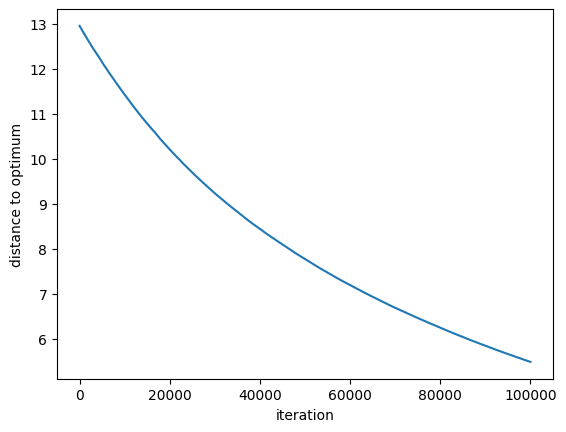

In [12]:
plot(dto)
xlabel("iteration");
ylabel("distance to optimum");

Is this actually optimal, though? Let's try some other step sizes!

In [13]:
Random.seed!(123456);
(w2, dto2) = sgd_logreg(w0, 5*alpha0, eta, X, Y, gamma, n_iters, wopt);
Random.seed!(123456);
(w3, dto3) = sgd_logreg(w0, 25*alpha0, 100*eta, X, Y, gamma, n_iters, wopt);

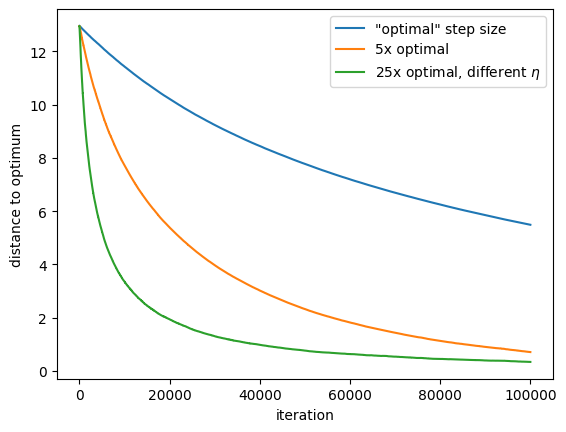

In [14]:
plot(dto; label = "\"optimal\" step size")
plot(dto2; label = "5x optimal")
plot(dto3; label = "25x optimal, different \$\\eta\$")
xlabel("iteration");
ylabel("distance to optimum");
legend();

<span class="question">What is the best assignment of the step size, in terms of the loss, after 20000 iterations?</span>

In [24]:
scale_factors = exp.(collect(-1:0.2:7));
dists = Float64[];
losses = Float64[]
for scale_factor in scale_factors
    Random.seed!(123456);
    (w, sgd_dists) = sgd_logreg(w0, scale_factor*alpha0, eta, X, Y, gamma, 20000, wopt);
    append!(dists, sgd_dists[end]);
    append!(losses, logreg_loss(w, X, Y, gamma));
end

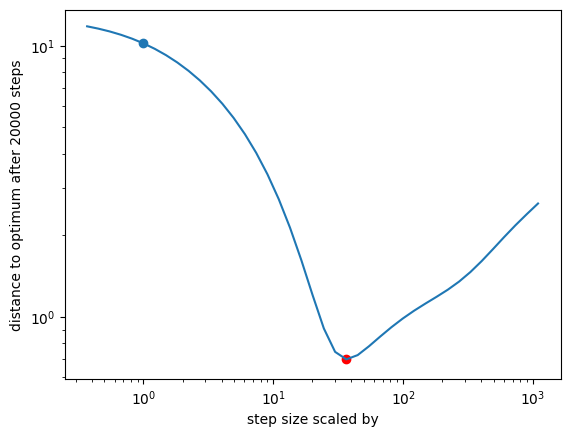

In [25]:
loglog(scale_factors, dists);
scatter(scale_factors[6], dists[6]);
(_, imin) = findmin(dists);
scatter(scale_factors[imin], dists[imin]; color="red");
xlabel("step size scaled by");
ylabel("distance to optimum after 20000 steps");

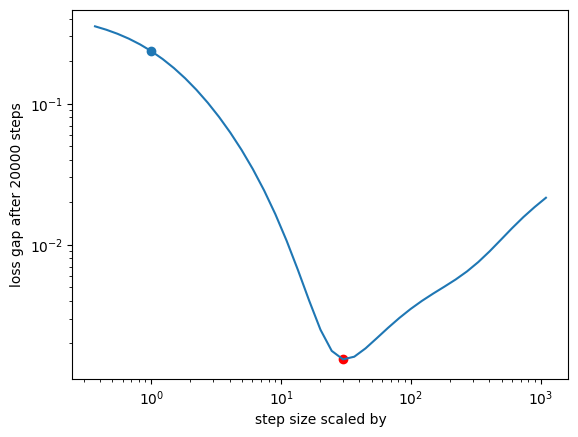

In [29]:
loglog(scale_factors, losses .- optimal_loss);
scatter(scale_factors[6], losses[6] - optimal_loss);
(_, imin) = findmin(losses);
scatter(scale_factors[imin], losses[imin] - optimal_loss; color="red");
xlabel("step size scaled by");
ylabel("loss gap after 20000 steps");

**Takeaway: the theory gave us something passable (at least it converged!), but not the best.**

**Summary:** the theory I showed you is doing something like
$$\arg \min_{\text{hyperparams}} \max_{\text{data}} \hspace{1em} \text{objective}.$$
It's finding a good set of hyperparameters that will work no matter what the data is, as long as the assumptions we made are satisfied.

**Key point:** This theoretical analysis does not use the training data at all to set the parameters. (Other than perhaps using it to calculate parameters like $\mu$ and $L$).

**Second key point:**  Theory only minimizes an upper bound on the objective...but the actual algorithm could do much better than the bound.

Motivating question: <span class="question">Can we use the data to improve our choice of parameters?</span>

## Hyperparameter Optimization

Any method that chooses hyperparameters automatically can be called hyperparameter optimization.

* This is also sometimes called "metaparameter optimization" or "tuning."

<span class="question">Question: What's the difference between hyperparameter optimization and regular training? To put it another way, when we use hyperparameter optimization to choose the hyperparameters based on the data, what's the difference between the model parameters and the hyperparameters?</span>

<div class="breakout">Breakout Discussion</div>

(...)

**Many possible goals of hyperparameter optimization:**

* Simplest setting: we just care about the accuracy of the model we are going to learn, so we just want to minimize the validation error.
* When we care about performance of our training process on hardware, we also need to factor in the cost of running training! This is especially important when we want to use hyperparameter optimization to select systems properties like the number of cores used for parallel training.
* When we care about performance of later inference with the learned model, we also need to factor in this cost of inference.

There are many ways to do hyperparameter optimization. Here are a few major categories.

### The simplest strategy: hyperparameters from folklore.

Idea: just set the hyperparameters by following what people have done in previous work on similar applications.

* Or, even what you can remember off the top of your head.

<span class="question">Examples?</span>

### Tradeoffs of using hyperparameters set from folklore:

* <span class="problem">Folklore can lead you astray.</span> It's relatively easy to find tasks for which the standard hyperparameter settings are wrong or suboptimal.

* **...but folklore is folklore for a reason.** These are hyperparameter settings that people have found empirically get good results. So it's likely that you will also get good results for your application if it's representitive of the type of applications for which others have observed these good results.

* Main benefit of using hyperparameters from previous work: you don't have to find the hyperparameters yourself! Minimizes your computational cost.

### The most complicated strategy: manual hyperparameter tuning.

Idea: just fiddle with the hyperparameters by hand until you either get the results you want or give up.

* Preferably this should be an expert human, but even non-experts can do good work here.
* This is probably the most common type of hyperparameter optimization used in practice (and you've done it before yourself in the programming assignments for this course). 
   * Also known (pejoratively) as "graduate student descent."

### Tradeoffs of tuning by hand:

* <span class="upside">Upside: Results are generally of high quality.</span> Humans are smart, and expert humans in particular can usually tease out good results if they are there.

* <span class="upside">Subsumes all other types of hyperparameter optimization.</span> A human tuner can always choose to use any other tuning method as input to their hand-tuning process.

* <span class="upside">There are a lot of humans.</span> And the vast majority of human time is as yet unused for hyperparameter optimization for machine learning models!

* <span class="problem">Downside: Human effort doesn't scale.</span> Especially expert human effort.

* <span class="problem">And it's a lot of effort.</span> Most humans would rather be doing something else.

* <span class="problem">And there's no theoretical guarantees.</span> Even if there is a good hyperparameter setting, there's no guarantee a particular human researcher will find it.

* <span class="problem">And it's hard to repeat the tuning process on a different dataset or problem.</span> Makes it difficult to replicate previous work.

### One automated method: Grid search.

* Idea: define some set of values you want to consider for each parameter.

* Form a grid from the Cartesian product of these sets.

* Then try all the parameter values in the grid, by running the whole system for each setting of the parameters.

* Then choose the setting that gives the best results (depending on the metric we care about).

The thing that we just did with plotting the performance of logistic-regression-SGD for many different step sizes and then picking the best one **is an instance of grid search**!

### Example of a grid for grid search on momentum SGD

Grid search would run the training algorithm for **all** of the circles in this diagram.

<center><img class="diagram" src="GridDiagram.png"></center>

### Tradeoffs of grid search:

* <span class="upside">Upside: Is guaranteed to explore the space.</span> Or at least it's guaranteed to explore the grid you told it to explore.

* <span class="upside">Highly replicable.</span> Anyone else can re-run your hyperparameter optimization algorithm easily.

* <span class="problem">Downside: Cost increases exponentially with the number of parameters.</span> This is the curse of dimensionality.

* <span class="problem">We still need some way to choose the grid properly.</span> Sometimes this can be almost as hard as the original hyperparameter optimization problem.

* <span class="problem">No way to take advantage of insight you have about the system</span> or about how the hyperparameters could interact.

### How can we make grid search fast?

Two simple tricks I'll mention here:

* **Early stopping.** Can abort some of the runs in the grid early if it becomes clear that they will be suboptimal.

* **Parallelism.** Grid search is an embarassingly parallel method. We can evaluate the grid points independently on parallel machines and get near-linear speedup. 

### Can we use one of our principles of large-scale machine learning to improve grid search?

Recall the two major principles we've discussed so far.

### $\blacktriangleright$ Combine grid search with subsampling. 

**The resulting method: Random search.**

* Idea: define some distribution over each parameter you want to explore.

* Take some number $N$ of random samples from the joint distribution of all the parameters.

* Try all those sampled values, by running the whole system for each setting of the parameters.

* Then choose the setting that gives the best results.

### Tradeoffs of random search vs grid search:

* <span class="upside">Upside: Solves the curse of dimensionality.</span> We often don't need to increase the number of sample points exponentially as the number of dimensions increases.

* <span class="problem">Downside: Not as replicable.</span> Results depend on a random seed.

* <span class="problem">Downside: Not necessarily going to go anywhere near the optimal parameters in a finite sample.</span>

* Same downsides as grid search: needing to choose the search space and no way of taking advantage of insight about the system.

### When does random search work better than grid search?

A quote:

> In this work we show that random search is more efficient than grid search in high-dimensional
spaces because functions $\Psi$ of interest have a low effective dimensionality; essentially, $\Psi$ of interest
are more sensitive to changes in some dimensions than others (Caflisch et al., 1997). In particular, if
a function $f$ of two variables could be approximated by another function of one variable ($f(x_1, x_2) \approx
g(x_1)$), we could say that $f$ has a low effective dimension.

from _"Random Search for Hyper-Parameter Optimization", Bergstra and Bengio_


### $\blacktriangleright$ Do hyperparameter search with optimization.

**One resulting method: Derivative-free optimization (DFO).**

* Idea: usually in hyperparameter optimization problems we can't automatically differentiate with respect to the hyperparameters (if the objective is even differentiable with respect to the hyperparameters at all).
  * Although sometimes we can, in which case gradient-based hyperparameter optimization methods are an option.

* But usually we can't use powerful large-scale optimization methods like GD and SGD.

* One class of methods that we can use is called **derivative-free optimization** methods.

* These methods solve an optimization problem without using derivative information.

* Instead they just use objective values (rather than objective gradients) to optimize.

* Just like SGD and GD, they (usually) operate by iteratively updating a value for the parameters by moving them in a direction that seems to decrease the loss.

Derivative free optimization is generally slow relative to other methods that can be used.
(In particular, it's often asymptotically slower than gradient-based methods when they can be used, which is why it isn't usually used for differentiable objective.)
But it still sees occasional use for hyperparameter optimization, as well as for cases where we want to minimize a loss that is not differentiable.

<span class="question">Question: how can we incorporate our own knowledge and insights about the problem into an optimization method?</span>

$\blacktriangleright$ One way to do this: **Bayesian Optimization.**

* Basically a "smart search" of the space that decides which hyperparameter setting to evaluate next based on past observations.

* Will search more nearby points observed to do well in the past.

* Unfortunately, we aren't going to cover this in depth, due to time lost from rescheduling.

* ...but it is a powerful tool you can learn to use!

# Summary

We learned about hyperparameter optimization, which describes techniques used to set hyperparameters.
We discussed why theoretical settings of hyperparameters aren't necessarily the ones we want to use in practice.
We discussed several methods for hyperparameter optimization:

* Hyperparameters from folklore

* Manual tuning

* Grid search

* Random search

* Bayesian optimization/derivative-free optimization

### Next time...a specific example: Scaling kernel machines!